In [8]:
# import cv2
import numpy as np
# from tqdm import tqdm # progress bar for loops
import os
import tensorflow as tf

DATASET_FOLER = "chest_xray_pneumonia_dataset"
TRAINING_FOLER = DATASET_FOLER + "/" + "train"
TESTING_FOLER = DATASET_FOLER + "/" + "test"
IMAGE_HEIGHT=150
IMAGE_WIDTH=150
COLOR_MODE='rgb'
IMAGE_CHANNELS = 3 if COLOR_MODE=='rgb' else 1
PATIENCE = 25
EPOCHS = 100

train_ds = tf.keras.utils.image_dataset_from_directory(
    TRAINING_FOLER,
    batch_size=32,
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    subset='training',
    validation_split=0.2,
    seed=42,
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    TRAINING_FOLER,
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=32,
    subset='validation',
    validation_split=0.2,
    seed=42,
)



Found 5216 files belonging to 2 classes.
Using 4173 files for training.
Found 5216 files belonging to 2 classes.
Using 1043 files for validation.


['NORMAL', 'PNEUMONIA']
(150, 150, 3)
(150, 150, 3)
(150, 150, 3)
(150, 150, 3)
(150, 150, 3)
(150, 150, 3)
(150, 150, 3)
(150, 150, 3)
(150, 150, 3)


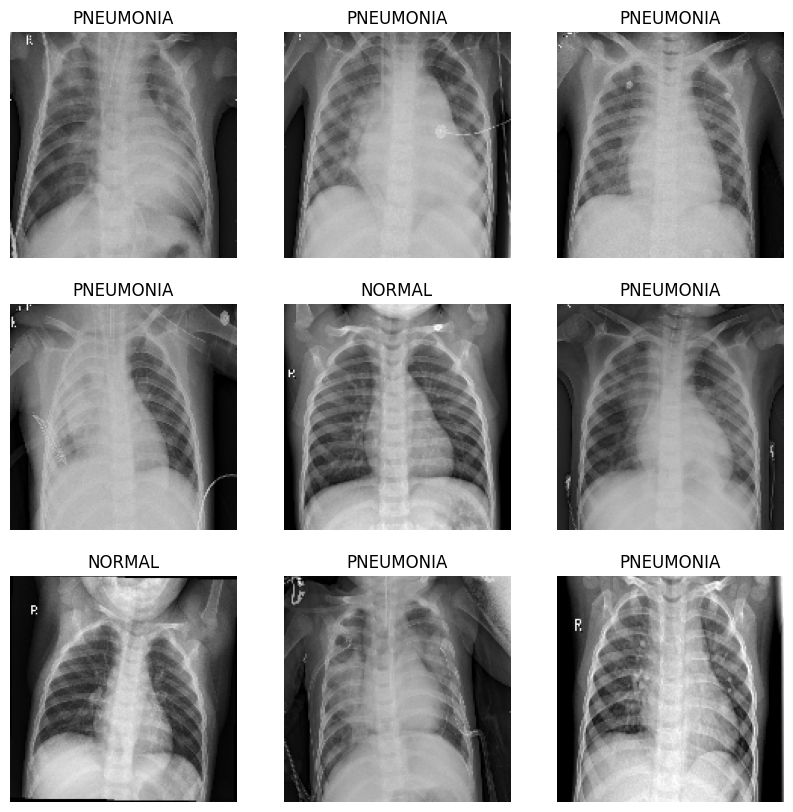

In [9]:
class_names = train_ds.class_names
print(class_names)


import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    print(images[i].shape)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [10]:
import tensorflow as tf
from tensorflow import keras

preprocessing = tf.keras.Sequential([
    tf.keras.layers.Resizing(IMAGE_HEIGHT, IMAGE_WIDTH),
    tf.keras.layers.Rescaling(1./255),
])

data_augmentation = keras.Sequential([
    keras.layers.RandomFlip("horizontal_and_vertical"),
    keras.layers.RandomRotation(1),
    keras.layers.RandomTranslation(0.2, 0.2),
    keras.layers.RandomZoom(0.2),
    keras.layers.RandomBrightness(0.2),
    keras.layers.RandomContrast(0.2),
])

train_ds.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=tf.data.AUTOTUNE)

<ParallelMapDataset element_spec=(TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [11]:
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization

model = Sequential()
model.add(keras.layers.Input(shape=(None, None, IMAGE_CHANNELS)))
model.add(preprocessing)

# model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (150,150,1)))
model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 1 , activation = 'sigmoid'))
model.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 150, 150, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 150, 150, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 150, 150, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 dropout (Dropout)           (None, 75, 75, 64)       

In [12]:
# model = keras.models.Sequential([
#     keras.layers.Input(shape=(None, None, IMAGE_CHANNELS)),

#     preprocessing,

#     keras.layers.Conv2D(32, 3, padding="same", activation="relu"),
#     keras.layers.Conv2D(64, 3, padding="same", activation="relu"),
#     keras.layers.MaxPooling2D(),
#     keras.layers.Dropout(0.2),

#     keras.layers.Conv2D(64, 3, padding="same", activation="relu"),
#     keras.layers.MaxPooling2D(),
#     keras.layers.Dropout(0.2),
    
#     keras.layers.Conv2D(128, 3, padding="same", activation="relu"),
#     keras.layers.MaxPooling2D(),
#     keras.layers.Dropout(0.2),

#     keras.layers.Conv2D(256, 3, padding="same", activation="relu"),
#     keras.layers.MaxPooling2D(),
#     keras.layers.Dropout(0.2),

#     # keras.layers.Conv2D(256, 3, padding="same", activation="relu"),
#     # # keras.layers.BatchNormalization(momentum=0.87),
#     # keras.layers.MaxPooling2D(),

#     keras.layers.GlobalAveragePooling2D(),

#     # keras.layers.Dropout(0.2),

#     keras.layers.Dense(1, activation="sigmoid"), #sigmoid is for binary classification
# ])


# model.compile(
#     optimizer=keras.optimizers.Adam(),
#     loss=keras.losses.BinaryCrossentropy(),
#     metrics=[keras.metrics.BinaryAccuracy()],
# )

# model.summary(
#     expand_nested=True,
# )

In [13]:
# train_ds = train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
# val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

earlystop_loss = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=PATIENCE, restore_best_weights=True)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[earlystop_loss],
)

Epoch 1/100


131/131 [==============================] - 36s 220ms/step - loss: 0.5156 - accuracy: 0.8775 - val_loss: 5.0161 - val_accuracy: 0.7613
Epoch 2/100
131/131 [==============================] - 15s 113ms/step - loss: 0.1862 - accuracy: 0.9358 - val_loss: 11.4017 - val_accuracy: 0.7613
Epoch 3/100
131/131 [==============================] - 16s 114ms/step - loss: 0.1430 - accuracy: 0.9545 - val_loss: 8.7856 - val_accuracy: 0.7613
Epoch 4/100
131/131 [==============================] - 15s 113ms/step - loss: 0.0882 - accuracy: 0.9741 - val_loss: 4.4109 - val_accuracy: 0.7785
Epoch 5/100
131/131 [==============================] - 15s 112ms/step - loss: 0.0883 - accuracy: 0.9712 - val_loss: 1.5775 - val_accuracy: 0.8552
Epoch 6/100
131/131 [==============================] - 15s 112ms/step - loss: 0.0706 - accuracy: 0.9794 - val_loss: 0.1074 - val_accuracy: 0.9799
Epoch 7/100
131/131 [==============================] - 15s 112ms/step - loss: 0.0722 - accuracy: 0.9792 - val_loss: 0.1804 - val_accura

KeyboardInterrupt: 

Epochs run: 39


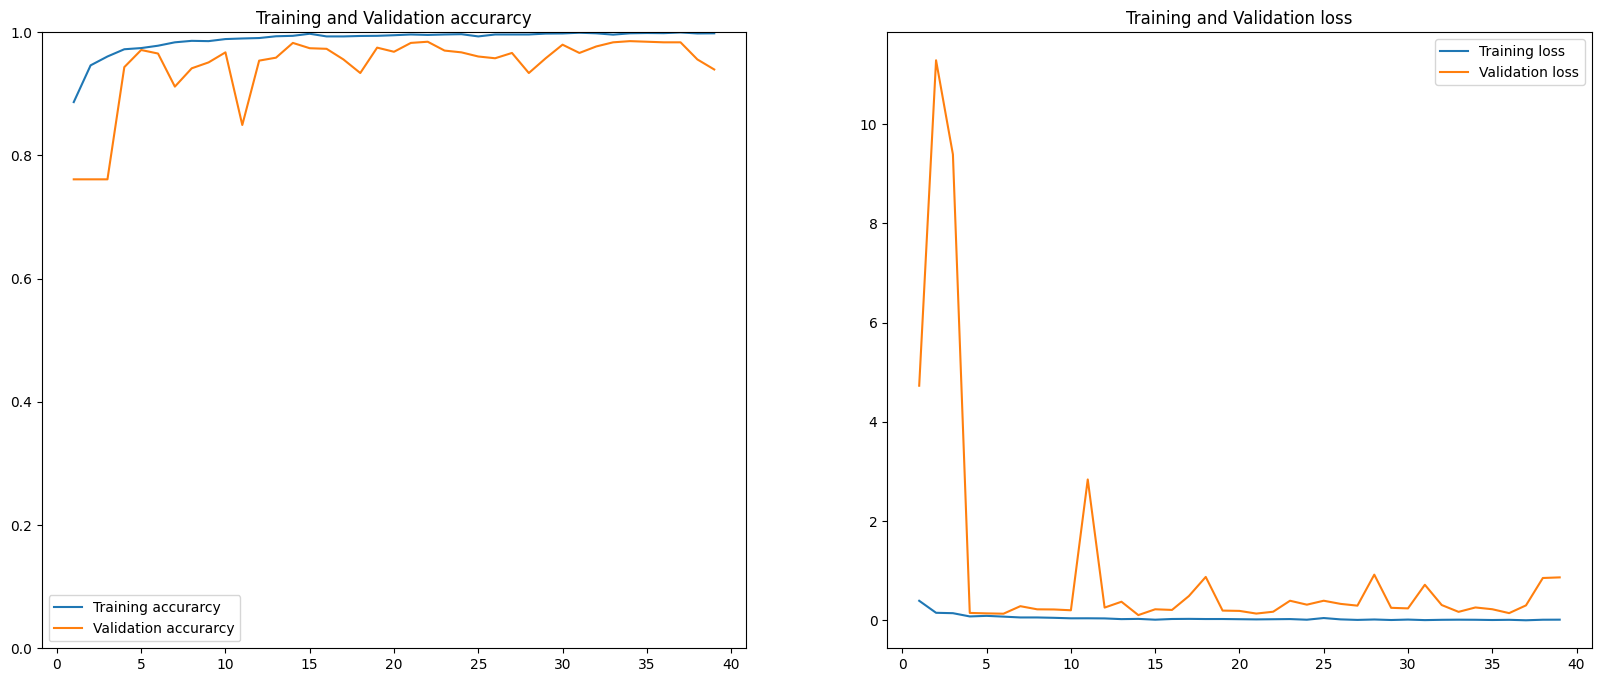

In [ ]:
from matplotlib import pyplot as plt

print("Epochs run:", len(history.history["loss"]))

acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)

# Train and validation accuracy
plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.ylim((0, 1))
plt.plot(epochs, acc, label="Training accurarcy")
plt.plot(epochs, val_acc, label="Validation accurarcy")
plt.title("Training and Validation accurarcy")
plt.legend()

# Train and validation loss
plt.subplot(1, 2, 2)

plt.plot(epochs, loss, label="Training loss")
plt.plot(epochs, val_loss, label="Validation loss")
plt.title("Training and Validation loss")
plt.legend()
plt.show()

In [ ]:
test_ds = keras.utils.image_dataset_from_directory(TESTING_FOLER,color_mode=COLOR_MODE)

y_pred = model.evaluate(test_ds, verbose=0)
prediction = model.predict(test_ds)

print("Test accuracy:", y_pred[1]*100)
print("Test loss:", y_pred[0]*100)

Found 624 files belonging to 2 classes.
20/20 [==============================] - 1s 40ms/step
Test accuracy: 73.87820482254028
Test loss: 360.50355434417725


Found 624 files belonging to 2 classes.
1/1 [==============================] - 0s 21ms/step


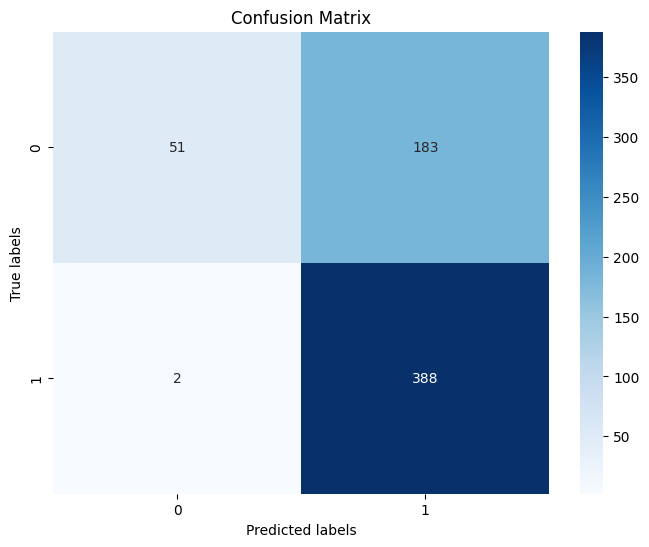

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Define your validation dataset
validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    TESTING_FOLER,
    image_size=(128, 128),
    batch_size=32)

# Get true labels and predicted probabilities
true_labels = []
predicted_probabilities = []

# Iterate over the validation dataset
for images, labels in validation_dataset:
    true_labels.extend(labels.numpy())
    predictions = model.predict(images)
    predicted_probabilities.extend(predictions)

# Convert probabilities to predicted labels
predicted_labels = np.where(np.array(predicted_probabilities) > 0.5, 1, 0)

# Convert true labels and predicted labels to numpy arrays
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

# Build the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
# SAVING THE MODEL

# save the iris classification model
model.save("pneumonia-cnn.h5")

In [ ]:
import tensorflow as tf

model.save("bt-cnn.h5") 
loaded_model = tf.keras.models.load_model("pneumonia-cnn.h5") 
loss, accuracy = loaded_model.evaluate(test_ds) 


20/20 [==============================] - 1s 41ms/step - loss: 1.9796 - binary_accuracy: 0.6827
